# LDA Topic Modeling on Song Lyrics

This notebooks performs LDA Topic Modeling on Song Lyrics [(see data source)](https://www.kaggle.com/albertsuarez/azlyrics).

In [37]:
%load_ext autoreload
%autoreload 2
import warnings
import csv
import os
import nltk
import pickle
from tqdm import tqdm
warnings.filterwarnings('ignore')
#execute the following of not downloaded already:
#nltk.download('wordnet')
#nltk.download('stopwords')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Step 1: Read CSV file and identify language

In [1]:
from langdetect import detect_langs
from langdetect.lang_detect_exception import LangDetectException

lyric_corpus = []
lang_filtered = 0
for filename in tqdm(os.listdir('azlyrics-scraper')):
    path = './azlyrics-scraper/'+filename
    with open(path, 'r') as f:
        data = csv.reader(f)
        headers = next(data) #skip headers
        for row in data:
            if len(row)< 5: #lyrics column not included
                continue
            if not row[4]: #lyrics are empty
                continue
            try:
                langlist = detect_langs(row[4])
                for l in langlist:
                    if l.prob < 0.95 or l.lang != 'en': #lyrics not clearly identified as English
                        lang_filtered += 1
                        continue
                    else:
                        lyric_corpus.append(row[4])
            except LangDetectException:
                continue

NameError: name 'tqdm' is not defined

In [5]:
print("Filtered", lang_filtered, "songs that had lyrics identified in a language other than English.", len(lyric_corpus), "songs remain for topic modeling")

Filtered 0 songs that had lyrics identified in a language other than English. 123794 songs remain for topic modeling


In [10]:
import pickle
fileObject = open("./data/lyric_corpus",'wb') 
pickle.dump(lyric_corpus, fileObject)   
fileObject.close()

## Step 2: Tokenization of Song Lyrics

All lyrics are currently stored as strings. First of all, each lyrics's text in the corpus is converted to lowercase letters.
The text strings are tokenized in order continue the text processing using the *RegexpTokenizer* and subsequently stored in *lyric_corpus_tokenized* for each paper object. Each word ('\w' refers to word characters, so alphanumerics) is now a string and each paper a list of strings.

In [12]:
from nltk.tokenize import RegexpTokenizer

lyric_corpus_tokenized = []
tokenizer = RegexpTokenizer(r'\w+')
for lyric in tqdm(lyric_corpus):
    tokenized_lyric = tokenizer.tokenize(lyric.lower())  #tokenize and lower each lyric
    lyric_corpus_tokenized.append(tokenized_lyric)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 123756/123756 [00:08<00:00, 15244.19it/s]


In [13]:
def count_token_in_corpus (corpus): #returns number of tokens for any given corpus
    return_count = 0
    for song in corpus:
        return_count += len(song)
    print("Total of", return_count, "tokens in the current corpus.")

In [14]:
count_token_in_corpus(lyric_corpus_tokenized)

Total of 31457627 tokens in the current corpus.


## Step 3: Removing Numeric and Tokens with less than 3 Characters

Tokens that only contain numbers or consist of only one letter are removed to reduce the dimensionality.

In [15]:
for s,song in tqdm(enumerate(lyric_corpus_tokenized)):
    filtered_song = []    
    for token in song:
        if len(token) > 2 and not token.isnumeric():
            filtered_song.append(token)
    lyric_corpus_tokenized[s] = filtered_song

123756it [00:04, 26088.26it/s]


In [16]:
count_token_in_corpus(lyric_corpus_tokenized)

Total of 22177055 tokens in the current corpus.


## Step 4: Token Lemmatization
*NLTK's WordNetLemmatizer* is imported, lemmatizing each token. This means each word is reduced to its stem or base form in order to enable better comparability. 

In [57]:
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

for s,song in tqdm(enumerate(lyric_corpus_tokenized)):
    lemmatized_tokens = []
    for token in song:
        lemmatized_tokens.append(lemmatizer.lemmatize(token))
    lyric_corpus_tokenized[s] = lemmatized_tokens

123794it [01:16, 1619.44it/s]


In [17]:
count_token_in_corpus(lyric_corpus_tokenized)

Total of 22177055 tokens in the current corpus.


## Step 5: Remove Stop Words and Profanities
In order to further reduce dimensionality, all words holding little to no value for topic modeling are removed. For this, *NLTK's stopwords*, a list of common stop words in the English language is imported and a few words that occured in previous modeling attempts are added.

In [21]:
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
new_stop_words = ['ooh','yeah','hey','whoa','woah', 'ohh', 'was', 'mmm', 'oooh','yah','yeh','mmm', 'hmm','deh','doh','jah','wa','ohhh']
stop_words.extend(new_stop_words)

for s,song in tqdm(enumerate(lyric_corpus_tokenized)):
    filtered_text = []    
    for token in song:
        if token not in stop_words:
            filtered_text.append(token)
    lyric_corpus_tokenized[s] = filtered_text

123756it [00:36, 3424.10it/s]


In [22]:
count_token_in_corpus(lyric_corpus_tokenized)

Total of 13772134 tokens in the current corpus.


Filter out profanities based on a predefined list

In [23]:
profanities = []
with open('profanity.txt', 'r') as file:
    prof_string = file.read().replace('\n', '')
    prof_tokens = prof_string.split(", ")
    for token in prof_tokens:
        profanities.append(token)

In [24]:
for s,song in tqdm(enumerate(lyric_corpus_tokenized)):
    filtered_text = []    
    for token in song:
        if token not in profanities:
            filtered_text.append(token)
    lyric_corpus_tokenized[s] = filtered_text

123756it [00:02, 55409.60it/s]


In [25]:
count_token_in_corpus(lyric_corpus_tokenized)

Total of 13708487 tokens in the current corpus.


In [26]:
# optionally store tokenized lyrics 
fileObject = open("./data/lyric_corpus_tokenized",'wb') 
pickle.dump(lyric_corpus_tokenized,fileObject)   
fileObject.close()

## Step 6: Dictionary Creation and Filtering

A dictionary representation of the lyrics is created (mapping all tokens to a unique ID).

In [28]:
from gensim.corpora import Dictionary

dictionary = Dictionary(lyric_corpus_tokenized)
print('Number of unique tokens: ', len(dictionary))

Number of unique tokens:  142915


In order to further reduce dimensionality, tokens that occur less than 100 songs, as well as tokens that occur in more than 80% of songs are removed

In [29]:
dictionary.filter_extremes(no_below = 100, no_above = 0.8)
print('Number of unique tokens: ', len(dictionary))

Number of unique tokens:  6259


## Step 7: Bag-of-Words and Index to Dictionary Conversion

Each song (as of now a list of tokens) is converted into the bag-of-words format, which only stores the unique token ID and its count for each song.
<br>
<font color='red'> All preprocessing should be done before this step! </font>

In [30]:
from gensim.corpora import MmCorpus

gensim_corpus = [dictionary.doc2bow(song) for song in lyric_corpus_tokenized]

#create index to dictionary
temp = dictionary[0]  # "loads" the dictionary
id2word = dictionary.id2token

## Step 8: Setting the Model Parameters

Before commencing training, the models' parameters have to be set. 
From *gensim* documentation:
- *chunksize* = the number of documents considered in each training cycle
- *passes* = number of passes through the corpus during training
- *iterations* = maximum number of iterations

In [31]:
# training parameters
chunksize = 2000
passes = 20
iterations = 400
num_topics = 6

## Step 9: Execute Training and calculate coherence

We train a LDA topic model for number of topics k (num_topics). Due to the large song corpus this may take some time.

In [62]:
from gensim.models import LdaModel
lda_model_auto = LdaModel(
    corpus=gensim_corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes
)






KeyboardInterrupt: 

In [120]:
models = []

In [63]:
pickle.dump(lda_model_auto, open('lda_model_auto.pkl', 'wb'))

In [65]:
lda_model_low_alpha = LdaModel(
    corpus=gensim_corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha=0.2,
    eta=0.8,
    iterations=iterations,
    num_topics=num_topics,
    passes=passes
)
pickle.dump(lda_model_low_alpha, open('lda_model_low_alpha.pkl', 'wb'))


In [66]:
lda_model_medium_alpha = LdaModel(
    corpus=gensim_corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha=0.4,
    eta=0.7,
    iterations=iterations,
    num_topics=num_topics,
    passes=passes
)
pickle.dump(lda_model_medium_alpha, open('lda_model_medium_alpha.pkl', 'wb'))

Calculate Cv coherence score (optional):

In [33]:
#from gensim.models.coherencemodel import CoherenceModel

#coherencemodel = CoherenceModel(model=lda_model, texts=lyric_corpus_tokenized, dictionary=dictionary, coherence='c_v')
#print(coherencemodel.get_coherence())

## Step 10: Visualize the LDA model using pyLDAvis
Visualize and store the models

In [36]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

vis_data = gensimvis.prepare(lda_model, gensim_corpus, dictionary)
#pyLDAvis.display(vis_data)
pyLDAvis.save_html(vis_data, './Lyrics_LDA_k_'+ str(num_topics) +'.html')



In [68]:
vis_data = gensimvis.prepare(lda_model_low_alpha, gensim_corpus, dictionary)
#pyLDAvis.display(vis_data)
pyLDAvis.save_html(vis_data, './Lyrics_LDA_low_alpha_k_'+ str(num_topics) +'.html')

In [69]:
vis_data = gensimvis.prepare(lda_model_medium_alpha, gensim_corpus, dictionary)
#pyLDAvis.display(vis_data)
pyLDAvis.save_html(vis_data, './Lyrics_LDA_medium_alpha_k_'+ str(num_topics) +'.html')

In [92]:
other_texts = [
    ['nigga', 'bitch', 'ass','drugs', 'what'],
    ['nigga', 'bitch', 'ass','drugs', 'what'],
    ['nigga', 'bitch', 'ass','drugs', 'what'],
]

In [93]:
other_corpus = [dictionary.doc2bow(text) for text in other_texts]



In [94]:
other_corpus

[[(6, 1), (17, 1), (108, 1), (243, 1)],
 [(6, 1), (17, 1), (108, 1), (243, 1)],
 [(6, 1), (17, 1), (108, 1), (243, 1)]]

In [95]:
unseen_doc = other_corpus[0]

In [96]:
    vector = lda_model[unseen_doc] 

In [97]:
vector

[(0, 0.06507676),
 (1, 0.09331651),
 (2, 0.07583396),
 (3, 0.06685592),
 (4, 0.5265511),
 (5, 0.17236573)]

In [98]:
unseen_doc = other_corpus[1]
lda_model[unseen_doc] 

[(0, 0.06507752),
 (1, 0.093316495),
 (2, 0.075833954),
 (3, 0.066862926),
 (4, 0.5265434),
 (5, 0.1723657)]

In [115]:
lda_model.print_topics()

[(0,
  '0.023*"man" + 0.021*"home" + 0.019*"little" + 0.017*"well" + 0.017*"old" + 0.012*"one" + 0.011*"said" + 0.011*"long" + 0.010*"back" + 0.009*"good"'),
 (1,
  '0.040*"get" + 0.037*"got" + 0.034*"baby" + 0.027*"like" + 0.026*"wanna" + 0.022*"let" + 0.021*"girl" + 0.019*"gonna" + 0.017*"want" + 0.016*"know"'),
 (2,
  '0.021*"away" + 0.018*"night" + 0.017*"like" + 0.015*"light" + 0.014*"eyes" + 0.013*"come" + 0.013*"see" + 0.011*"sun" + 0.010*"let" + 0.010*"run"'),
 (3,
  '0.018*"god" + 0.017*"life" + 0.011*"lord" + 0.010*"world" + 0.010*"soul" + 0.008*"die" + 0.008*"name" + 0.007*"free" + 0.007*"live" + 0.007*"jesus"'),
 (4,
  '0.030*"like" + 0.022*"nigga" + 0.021*"got" + 0.016*"bitch" + 0.015*"niggas" + 0.014*"money" + 0.013*"get" + 0.009*"know" + 0.008*"man" + 0.007*"gon"'),
 (5,
  '0.047*"love" + 0.033*"know" + 0.021*"never" + 0.017*"time" + 0.016*"one" + 0.014*"say" + 0.014*"way" + 0.013*"could" + 0.011*"see" + 0.011*"cause"')]

In [113]:
sample = [(0, 2), (4, 1), (6, 1), (99, 2), (161, 1), (162, 1), (166, 1), (167, 2), (171, 2)]
sample2 = [(6, 1), (17, 1), (108, 1), (243, 1)]

In [114]:
lda_model_medium_alpha[sample] 

[(0, 0.028218556),
 (1, 0.45481786),
 (2, 0.028379845),
 (3, 0.4247329),
 (4, 0.036950085),
 (5, 0.026900757)]

In [116]:
lda_model_more_iterations = LdaModel(
    corpus=gensim_corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations*2,
    num_topics=num_topics,
    passes=passes
)

In [117]:
pickle.dump(lda_model_more_iterations, open('lda_model_more_iterations.pkl', 'wb'))

In [118]:
lda_model_more_iterations.print_topics()

[(0,
  '0.014*"away" + 0.011*"see" + 0.009*"eyes" + 0.009*"like" + 0.008*"time" + 0.007*"light" + 0.007*"never" + 0.007*"life" + 0.007*"still" + 0.007*"day"'),
 (1,
  '0.118*"love" + 0.045*"baby" + 0.029*"let" + 0.027*"heart" + 0.024*"one" + 0.020*"come" + 0.015*"never" + 0.015*"hold" + 0.012*"give" + 0.012*"need"'),
 (2,
  '0.043*"know" + 0.020*"like" + 0.019*"want" + 0.018*"got" + 0.018*"get" + 0.017*"cause" + 0.017*"say" + 0.016*"wanna" + 0.015*"time" + 0.014*"make"'),
 (3,
  '0.031*"like" + 0.026*"got" + 0.023*"nigga" + 0.021*"get" + 0.017*"bitch" + 0.015*"niggas" + 0.015*"money" + 0.009*"gon" + 0.007*"hit" + 0.006*"real"'),
 (4,
  '0.033*"god" + 0.023*"lord" + 0.014*"life" + 0.014*"sing" + 0.013*"jesus" + 0.012*"soul" + 0.011*"world" + 0.011*"name" + 0.011*"christmas" + 0.011*"heaven"'),
 (5,
  '0.017*"got" + 0.016*"man" + 0.015*"get" + 0.015*"like" + 0.011*"little" + 0.010*"come" + 0.009*"well" + 0.008*"dance" + 0.008*"girl" + 0.008*"old"')]

In [119]:
vis_data = gensimvis.prepare(lda_model_more_iterations, gensim_corpus, dictionary)
#pyLDAvis.display(vis_data)
pyLDAvis.save_html(vis_data, './Lyrics_LDA_more_iterations'+ str(num_topics) +'.html')



In [121]:
models.append(lda_model_more_iterations)
models.append(lda_model)
models.append(lda_model_medium_alpha)
models.append(lda_model_low_alpha)

In [124]:
from gensim.models.coherencemodel import CoherenceModel

for model in models:
    coherencemodel = CoherenceModel(model=model, texts=lyric_corpus_tokenized, dictionary=dictionary, coherence='c_v')
    print(coherencemodel.get_coherence())

0.40566845175105
0.4122572524395996
0.3971562826887953
0.40341123378787414


In [125]:
lda_model_very_low_alpha = LdaModel(
    corpus=gensim_corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha=0.1,
    eta=0.9,
    iterations=iterations*2,
    num_topics=5,
    passes=passes
)
pickle.dump(lda_model_very_low_alpha, open('lda_model_very_low_alpha.pkl', 'wb'))
vis_data = gensimvis.prepare(lda_model_very_low_alpha, gensim_corpus, dictionary)
#pyLDAvis.display(vis_data)
pyLDAvis.save_html(vis_data, './Lyrics_LDA_very_low_alpha'+ str(num_topics) +'.html')

In [127]:
models.append(lda_model_very_low_alpha)

In [128]:
coherencemodel = CoherenceModel(model=lda_model_very_low_alpha, texts=lyric_corpus_tokenized, dictionary=dictionary, coherence='c_v')
coherencemodel.get_coherence()

0.4019135601214713

In [129]:
lda_model_auto_5 = LdaModel(
    corpus=gensim_corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=5,
    passes=passes
)
pickle.dump(lda_model_auto_5, open('lda_model_auto_5.pkl', 'wb'))
vis_data = gensimvis.prepare(lda_model_auto_5, gensim_corpus, dictionary)
#pyLDAvis.display(vis_data)
pyLDAvis.save_html(vis_data, './Lyrics_LDA_auto_5'+ str(num_topics) +'.html')

In [130]:
models.append(lda_model_auto_5)
coherencemodel = CoherenceModel(model=lda_model_auto_5, texts=lyric_corpus_tokenized, dictionary=dictionary, coherence='c_v')
coherencemodel.get_coherence()

0.40687289640590507

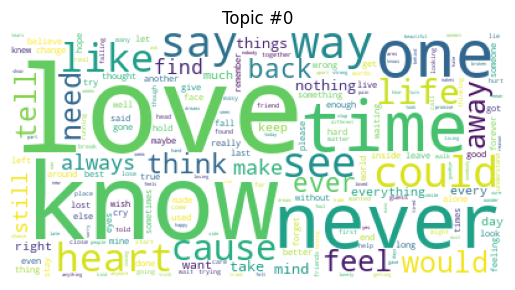

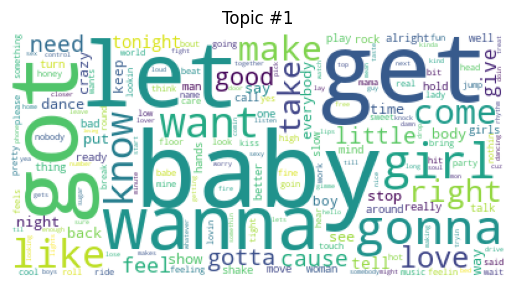

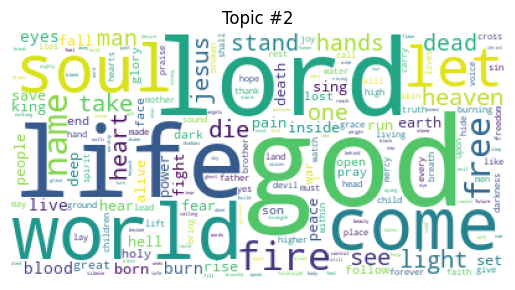

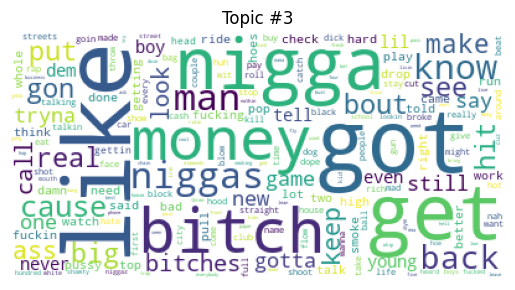

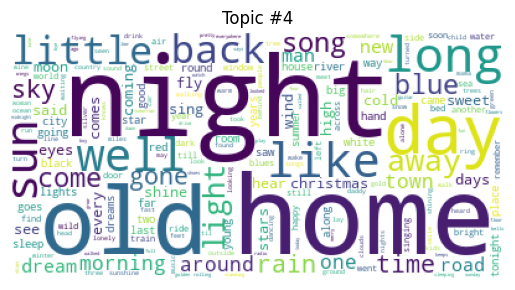

In [141]:
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
import gensim
import matplotlib.pyplot as plt
from wordcloud import WordCloud

for t in range(lda_model_auto_5.num_topics):
    plt.figure( )
    plt.imshow(WordCloud(background_color='white',collocations=False).fit_words(dict(lda_model_auto_5.show_topic(t, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()